Here, we assess which features were ranked as most important for our model:

In [1]:
import os

from tqdm import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import read_pickled_object

In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 3

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [14]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)
feature_names = X.columns
X = X.values

y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)['mean'].values.ravel()

best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 'best_model.pickle'))


Fit on the full dataset:

In [16]:
best_pipeline.fit(X, y)
model_coefs = best_pipeline.named_steps['model'].coef_.flatten()
np.savetxt(os.path.join(data_path, 'interim', 'transcriptomics_consensus_coefs.txt'), model_coefs)

''

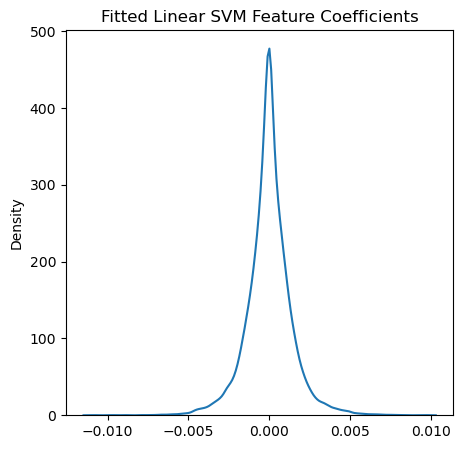

In [20]:
fig, ax = plt.subplots(figsize = (5,5))

sns.kdeplot(model_coefs, ax = ax)
ax.set_title('Fitted Linear SVM Feature Coefficients')
;

Let's take the top 500 features by absolute value of the model coefficients:

In [29]:
# top_n_frac = 0.05
# top_n = int(np.round(top_n_frac * X.shape[1]))
top_n = 500

feature_importance = np.abs(model_coefs) 
ranked_features = np.argsort(feature_importance)[::-1] 
ranked_features = ranked_features[:top_n]
ranked_feature_names = [feature_names[i] for i in ranked_features]

top_features = pd.DataFrame(data = {'SVM coefficient': model_coefs[ranked_features],
                                    'Gene Name': ranked_feature_names})


Text(0.5, 0, 'Genes')

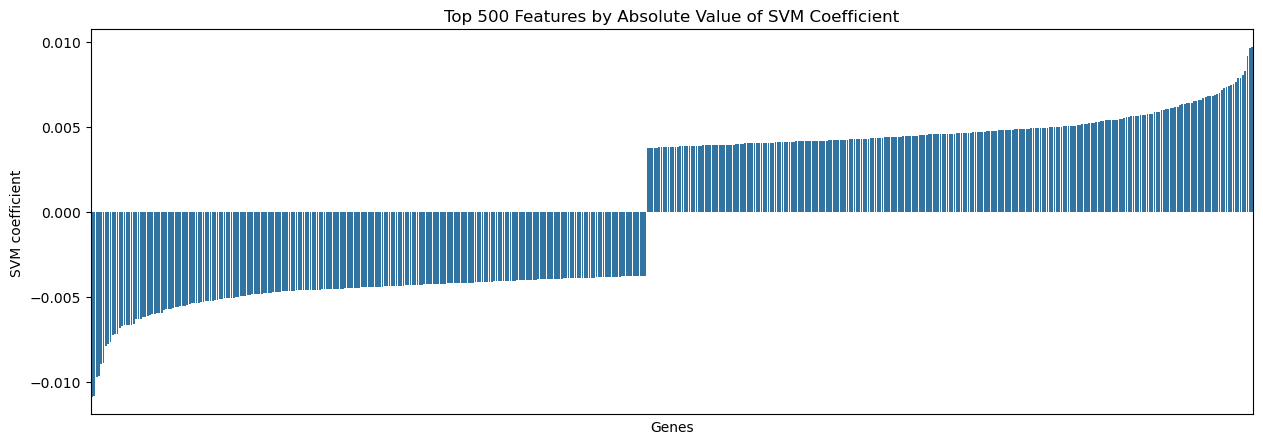

In [48]:
fig, ax = plt.subplots(figsize = (15, 5))

viz_df = top_features.sort_values(by = 'SVM coefficient', ascending = True)

sns.barplot(data = viz_df, x = 'Gene Name', y = 'SVM coefficient', ax = ax)
ax.set_xticklabels([])
ax.set_title('Top 500 Features by Absolute Value of SVM Coefficient')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_xlabel('Genes')

Let's run an over-representation analysis of the positive and negative highly ranked features:

In [61]:
top_features_negative = top_features[top_features['SVM coefficient'] < 0]
top_features_positive = top_features[top_features['SVM coefficient'] > 0]